## Batching

In [1]:
# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

import warnings
warnings.filterwarnings("ignore")

In [2]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

In [3]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

In [4]:
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

### Trainer At Diff Batch Size

In [5]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11, 16)
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 32)

        self.output = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        x = self.output(x)

        return x

def ModelTrainer(batch_size: int):
    model = Model()
    lossfunc = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100

    losses = torch.zeros(epochs)

    
    train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
    test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0], shuffle = True)

    trainAcc = []
    testAcc = []


    for i in range(epochs):
        model.train()

        batchAcc = []
        batchLoss = []

        for x,y in train_loader:
            yhat = model(x)
            loss = lossfunc(yhat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(100*(yhat>0).float().eq(y).sum().item()/len(yhat))
        trainAcc.append(np.mean(batchAcc))
        losses[i] = np.mean(batchLoss)

        model.eval()
        X,y = next(iter(test_loader))
        with torch.no_grad():
            yhat = model(X)
        testAcc.append(100*(yhat>0).float().eq(y).sum().item()/len(yhat))
    return trainAcc,testAcc,losses
        

In [6]:
batchsizes = [2,8,16,32,128,512]

accuracyResultsTrain = np.zeros((100,len(batchsizes)))
accuracyResultsTest  = np.zeros((100,len(batchsizes)))
comptime             = np.zeros(len(batchsizes))

In [7]:
for bi in range(len(batchsizes)):
    starttime = time.process_time()
    trainAcc,testAcc,losses = ModelTrainer(batchsizes[bi])
    comptime[bi] = time.process_time() - starttime
    print(f"Batch size {batchsizes[bi]} took {comptime[bi]:.2f} seconds")
    accuracyResultsTrain[:,bi] = trainAcc
    accuracyResultsTest[:,bi]  = testAcc

Batch size 2 took 23.13 seconds
Batch size 8 took 6.36 seconds
Batch size 16 took 3.39 seconds
Batch size 32 took 1.88 seconds
Batch size 128 took 0.75 seconds
Batch size 512 took 0.63 seconds


### Plot MiniBatch

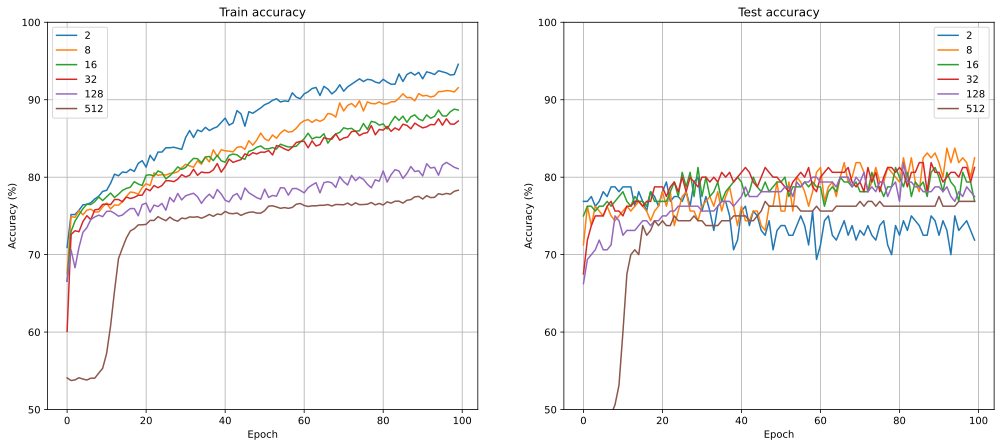

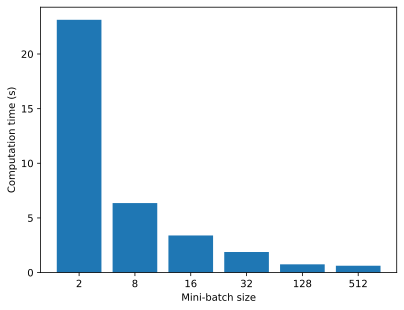

In [8]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title('Train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('Test accuracy')

# common features
for i in range(2):
  ax[i].legend(batchsizes)
  ax[i].set_xlabel('Epoch')
  ax[i].set_ylabel('Accuracy (%)')
  ax[i].set_ylim([50,100])
  ax[i].grid()

plt.show()

# bar plot of computation time
plt.bar(range(len(comptime)),comptime,tick_label=batchsizes)
plt.xlabel('Mini-batch size')
plt.ylabel('Computation time (s)')
plt.show()